# <span style="color:red">Análisis de datos en Python</span>


> Adrián Felipe Hernández Borda
>

>
> Universidad Pedagógica y Tecnológica de Colombia $\Big[\text{UPTC}\Big]$
>
> Universidad Aurónoma de Sinaloa $\Big[\text{UAS}\Big]$
>



El presente es un cuaderno de trabajo, pruebas y avances sobre el proyecto desarrollado en la **optativa de análisis de datos en python**
## <span style="color:rgb(0,180,200)">Objetivos</span>

Predecir las calificaciones (***Promedio / Matemática, Escritura y Lectura***)  de estudiantes con base a algunas características de su entorno y vida personal


# <span style="color:rgb(180,200,0)">Importar librerías</span>


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
sns.set_style(style="ticks")
from os import cpu_count as ncpu
from multiprocessing import Pool as pool
from fitter import Fitter as ftr

#%matplotlib widget


## <span style="color:rgb(180,200,0)">Importar datos</span>


Usando variables de cadenas de caracteres que contienen la ruta del conjunto de datos se importa el csv.

In [2]:
path = "./datasets/"
#file = "global-data-on-sustainable-energy.csv"
file = "Expanded_data_with_more_features.csv"
#file_exp = "Original_data_with_more_rows.csv"
full_path = path+file
#full_path_exp = path+file_exp
print(f"Dirección del conjunto de datos: '{full_path:s}'")


Dirección del conjunto de datos: './datasets/Expanded_data_with_more_features.csv'


In [3]:
data = pd.read_csv(full_path,sep=",")
sz = data.shape
print(f"Número de variables -> {sz[0]}\nEntradas del conjunto de datos -> {sz[1]}")

print("\n--- CABECERA DEL CONJUNTO DE DATOS ---\n")
display(data.head())

print("\n--- DESCRIPCIÓN ---\n")
display(data.info())

Número de variables -> 30641
Entradas del conjunto de datos -> 15

--- CABECERA DEL CONJUNTO DE DATOS ---



,ID,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75



--- DESCRIPCIÓN ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   30641 non-null  int64  
 1   Gender               30641 non-null  object 
 2   EthnicGroup          28801 non-null  object 
 3   ParentEduc           28796 non-null  object 
 4   LunchType            30641 non-null  object 
 5   TestPrep             28811 non-null  object 
 6   ParentMaritalStatus  29451 non-null  object 
 7   PracticeSport        30010 non-null  object 
 8   IsFirstChild         29737 non-null  object 
 9   NrSiblings           29069 non-null  float64
 10  TransportMeans       27507 non-null  object 
 11  WklyStudyHours       29686 non-null  object 
 12  MathScore            30641 non-null  int64  
 13  ReadingScore         30641 non-null  int64  
 14  WritingScore         30641 non-null  int64  
dtypes: float64(1),

None


# <span style="color:rgb(180,200,0)">Descripción del conjunto de datos</span>



## Variables 
### Categóricas
1. `Gender`
2. `EthnicGroup` 
3. `ParentMaritalStatus`
4. `PracticeSport`
5. `IsFirstChild`
6. `TransportMeans`


### Ordinales
1. `LunchType` **Basado en que la merienda da energía que consume el cerebro**
2. `TestPrep`
3. `ParentEduc` **Basado en el grado de escolaridad**
4. `WklyStudyHours` **Son intervalos de tiempo, no es un número de punto flotante**

### Cuantitativas (Discretas)
1. `ID` **No aporta información para el análisis del conjunto de datos**
2. `NrSiblings`
3. `MathScore`
4. `ReadingScore`
5. `WritingScore` 

---
# <span style="color:rgb(180,200,0)">Reescritura del conjunto de datos</span>

---
Ahora el propósito es asignar a cada valor de una variable categórica un número entero, primero se crea unas funciones que permitan reemplazar los datos de un dataset por números. 

In [4]:
# Función que reemplaza los valores  de acuerdo a como aparezcan al leer de arriba abajo el conjunto de datos

def replace_values(df:pd.DataFrame):
    values = list(pd.get_dummies(df,prefix='',prefix_sep='').columns.values)
    print(values)
    new_values = [k+1 for k in range(len(values)) ]
    dic = dict(map(lambda x,y:(x,y),values,new_values))
    df = df.replace(to_replace=dic)
    print(f"{df.keys()[0]} -> {dic}")
    return df

# Función que reemplaza una columna de un conjunto de datos

def replace_col(df_main:pd.DataFrame,df_col:pd.DataFrame):
    df_main = df_main.drop(labels=df_col.keys()[0],axis=1)
    df_main = pd.concat([df_main,df_col],axis=1)
    return df_main

Ahora se puede seleccionar las columnas de las variables categóricas  de acuerdo a la inspección previa. Posteriormente el conjunto de datos se puede separar en tres conjuntos más sencillos a los que se aplicará las funciones definidas.

In [5]:
cols_categoric = ["Gender","EthnicGroup","ParentMaritalStatus","PracticeSport","IsFirstChild","TransportMeans"]
cols_ordinal = ["LunchType","TestPrep","ParentEduc","WklyStudyHours"]
cols_cuantitative = ["ID","NrSiblings","MathScore","ReadingScore","WritingScore"]

# datos redundantes

cols_objective = ["MathScore","ReadingScore","WritingScore"] # objetivo
cols_numbers = ["LunchType","TestPrep","ParentEduc","WklyStudyHours"] # datos numéricos no objetivo

data_ordinal = data[cols_ordinal]
data_categoric = data[cols_categoric]
data_cuantitative = data[cols_cuantitative]

Una forma de asignar valores numéricos para las variables categóricas es el siguiente ya que:
> No distingue jerarquía para los ordinales

In [6]:
for cols in cols_categoric:
    data_categoric = replace_col( data_categoric,replace_values(data_categoric[[cols]]) )


data_ordinal = replace_col(data_ordinal,data_ordinal[["LunchType"]].replace(to_replace={'standard': 2, 'free/reduced': 1}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["WklyStudyHours"]].replace(to_replace={'< 5': 1, '5 - 10': 2, '> 10': 3}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["ParentEduc"]].replace(to_replace={"bachelor's degree": 4, 'some college': 3, "master's degree": 6, "associate's degree": 5, 'high school': 2, 'some high school': 1}))
data_ordinal = replace_col(data_ordinal,data_ordinal[["TestPrep"]].replace(to_replace={'none': 1, 'completed': 2}))

['female', 'male']
Gender -> {'female': 1, 'male': 2}
['group A', 'group B', 'group C', 'group D', 'group E']
EthnicGroup -> {'group A': 1, 'group B': 2, 'group C': 3, 'group D': 4, 'group E': 5}
['divorced', 'married', 'single', 'widowed']
ParentMaritalStatus -> {'divorced': 1, 'married': 2, 'single': 3, 'widowed': 4}
['never', 'regularly', 'sometimes']
PracticeSport -> {'never': 1, 'regularly': 2, 'sometimes': 3}
['no', 'yes']
IsFirstChild -> {'no': 1, 'yes': 2}
['private', 'school_bus']
TransportMeans -> {'private': 1, 'school_bus': 2}


Las variables ordinales toman valores que se mapearon a valores numéricos con base en el algoritmo de identifiación de resultados como sigue

In [7]:
data_number = pd.concat([data_cuantitative,data_ordinal,data_categoric],axis=1)

print("--- CONJUNTO DE DATOS NUMÉRICO ---")
      
display(data_number.head())

data_number.to_csv(path_or_buf="./data_num_new.csv",sep=",")

del [data_categoric,data_ordinal,data_cuantitative]

--- CONJUNTO DE DATOS NUMÉRICO ---


,ID,NrSiblings,MathScore,ReadingScore,WritingScore,LunchType,WklyStudyHours,ParentEduc,TestPrep,Gender,EthnicGroup,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans
0,0,3.0,71,71,74,2,1.0,4.0,1.0,1,NaN,2.0,2.0,2.0,2.0
1,1,0.0,69,90,88,2,2.0,3.0,NaN,1,3.0,2.0,3.0,2.0,NaN
2,2,4.0,87,93,91,2,1.0,6.0,1.0,1,2.0,3.0,3.0,2.0,2.0
3,3,1.0,45,56,42,1,2.0,5.0,1.0,2,1.0,2.0,1.0,1.0,NaN
4,4,0.0,76,78,75,2,2.0,3.0,1.0,2,3.0,2.0,3.0,2.0,2.0


In [8]:
for df in data_number.columns.values:
    data_number[[df]] = data_number[[df]].fillna(value=round(np.mean(data_number[df])))

objective = pd.DataFrame({"MeanScore":np.mean(data_number[cols_objective],axis=1)})
data_number = pd.concat([data_number,objective],axis=1)

In [9]:
data_number.head()

,ID,NrSiblings,MathScore,ReadingScore,WritingScore,LunchType,WklyStudyHours,ParentEduc,TestPrep,Gender,EthnicGroup,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans,MeanScore
0,0,3.0,71,71,74,2,1.0,4.0,1.0,1,3.0,2.0,2.0,2.0,2.0,72.000000
1,1,0.0,69,90,88,2,2.0,3.0,1.0,1,3.0,2.0,3.0,2.0,2.0,82.333333
2,2,4.0,87,93,91,2,1.0,6.0,1.0,1,2.0,3.0,3.0,2.0,2.0,90.333333
3,3,1.0,45,56,42,1,2.0,5.0,1.0,2,1.0,2.0,1.0,1.0,2.0,47.666667
4,4,0.0,76,78,75,2,2.0,3.0,1.0,2,3.0,2.0,3.0,2.0,2.0,76.333333


In [10]:
data_number.to_csv(path_or_buf="./data_number_no_nan.csv",sep=',')


Como las primera columna resultó de guardar el dataframe a un archivo nuevo, es decir que se asigna un identificador ascendente a cada valor del dataframe, se puede suprimir. 

In [11]:
data_number = data_number.iloc[:,1:]

## <span style="color:rgb(180,0,180)">DISCRETIZACIÓN DEL TARGET</span>

In [12]:
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=6,strategy='uniform',encode='ordinal')

In [13]:
discrete_obj = []

for col in cols_objective+['MeanScore']:
    discrete_obj.append(discretizer.fit_transform(np.reshape(data_number[col],(-1,1))))

for k,name in enumerate(cols_objective + ['MeanScore']):
    discrete_obj[k] = pd.DataFrame(discrete_obj[k],columns=[name + "Disc"])

data_number = pd.concat([data_number]+discrete_obj,axis=1)

cols_objective_disc = [col + 'Disc' for col in cols_objective]



# <span style="color:rgb(180,200,0)">Estandarización del conjunto de datos</span>





Ahora se busca mapear cada entrada $x$ de cada variable del dataframe a un número $x'$ entre el intervalo $[0,1]$ de manera que
$$\max(x)=\chi\to1,\qquad \min(x)=\beta\to0$$
siendo $x$  un elemento de una columna del data frame, incluyendo el máximo y el mínimo se debe satisfacer que:

$$\min(x)-\beta=0=\min(x')$$
$$\dfrac{\max(x)-\beta}{\chi-\beta}=1=\max(x')$$

de manera que en general se tiene

$$x'=\dfrac{x-\beta}{\chi-\beta}$$

aplicando ese mapeo se obtiene:

In [14]:
data_norm = pd.concat([(data_number.iloc[:,k]-min(data_number.iloc[:,k])) / (max(data_number.iloc[:,k])-min(data_number.iloc[:,k])) for k in range(data_number.shape[1])],axis=1)
data_norm.to_csv(path_or_buf="./data_normalized.csv",sep=',')

In [15]:
def corr_matrix (df:pd.DataFrame):
    fig,axes = plt.subplots(ncols=1,nrows=1,figsize=(20,10))
    
    corr = df.corr()
    sns.heatmap(data=corr,
                annot=True,
                fmt=".1e",
                annot_kws={"fontsize":12},
                cbar=True,
                cmap="vlag",
                linewidth=.5)
    plt.show()

## Datos normalizados

/home/adrian/miniconda3/envs/adat/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


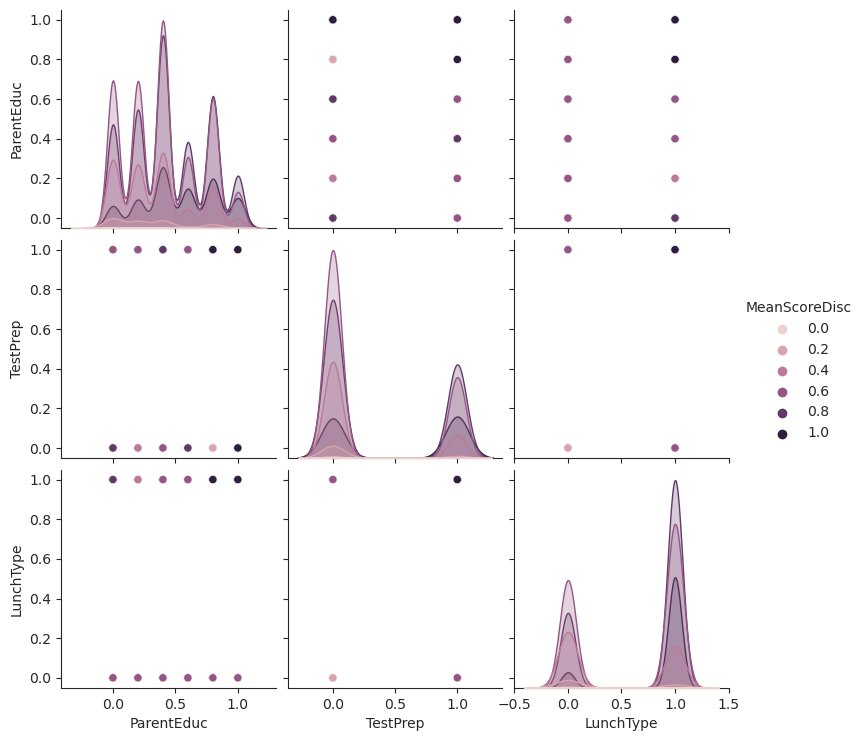

In [16]:
sns.pairplot(data=data_norm,x_vars=['ParentEduc','TestPrep','LunchType'],y_vars=['ParentEduc','TestPrep','LunchType'],hue='MeanScoreDisc')

Como la matriz de correlación no cambia, tenemos que **¡el dataset quedó bien normalizado!**; Además, como se puede ver en la matrix de correlación, la variable ID no aporta, de manera que vale la pena quitarla

In [17]:
cols_cuantitaive = ['MathScore', 'ReadingScore', 'WritingScore'] # igual que objective??

## Estadística del conjunto de datos
para los histogrmas los intervalos se dan por la regla de sturges:
$$N_{\text{bins}} = \text{int}\left(1+\log_{2}(N_{\text{registers}})\right)$$

In [18]:

bins = round(1 + np.log2(sz[0]) ) # sz es el 'shape' del dataframe
print(f"la cantidad de intervalos es {bins: 2d}")

fntsz = 10 # Tamaño de letra para los plots

la cantidad de intervalos es  16


In [19]:
pd.DataFrame(data_norm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NrSiblings           30641 non-null  float64
 1   MathScore            30641 non-null  float64
 2   ReadingScore         30641 non-null  float64
 3   WritingScore         30641 non-null  float64
 4   LunchType            30641 non-null  float64
 5   WklyStudyHours       30641 non-null  float64
 6   ParentEduc           30641 non-null  float64
 7   TestPrep             30641 non-null  float64
 8   Gender               30641 non-null  float64
 9   EthnicGroup          30641 non-null  float64
 10  ParentMaritalStatus  30641 non-null  float64
 11  PracticeSport        30641 non-null  float64
 12  IsFirstChild         30641 non-null  float64
 13  TransportMeans       30641 non-null  float64
 14  MeanScore            30641 non-null  float64
 15  MathScoreDisc        30641 non-null 

""




# <span style="color:rgb(180,200,0)">Distribución de variables</span>



# ¿Vale la pena poner un sólo target?

In [20]:
def fits(df:pd.DataFrame):
    f_df = ftr(df,distributions=["gamma"])
    f_df.fit()
    return f_df.summary()

In [21]:
dfs = [data_norm[col] for col in list(cols_objective + ["MeanScore"])]

with pool(ncpu()) as p:
    fit_info = p.map(fits,dfs)
plt.show()

In [22]:
display(pd.concat(fit_info,axis=0))

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,29.458659,312.293610,337.283892,inf,0.031857,1.889792e-27
gamma,21.207738,254.194607,279.184890,inf,0.032866,3.438016e-29
gamma,9.479230,283.450685,308.440968,inf,0.027224,3.671023e-20
gamma,5.661997,259.120841,284.111124,inf,0.023131,1.127875e-14


## Métricas
---
> suma de error cuadrático

---
> Criterio de información de Akaike

---

> Criterio de información Bayesiano

---
> Divergencia de Kullback-Liebler


> Kolmogórov-Smirnov KS
>
> p-value

---



 


La respuesta es no, ya que una de las distribuciones se ajusta mejor a la función de distribución gamma y no las 3; sin emargo vamos a añadir el promedio al dataset para ver su comportamiento como objetivo

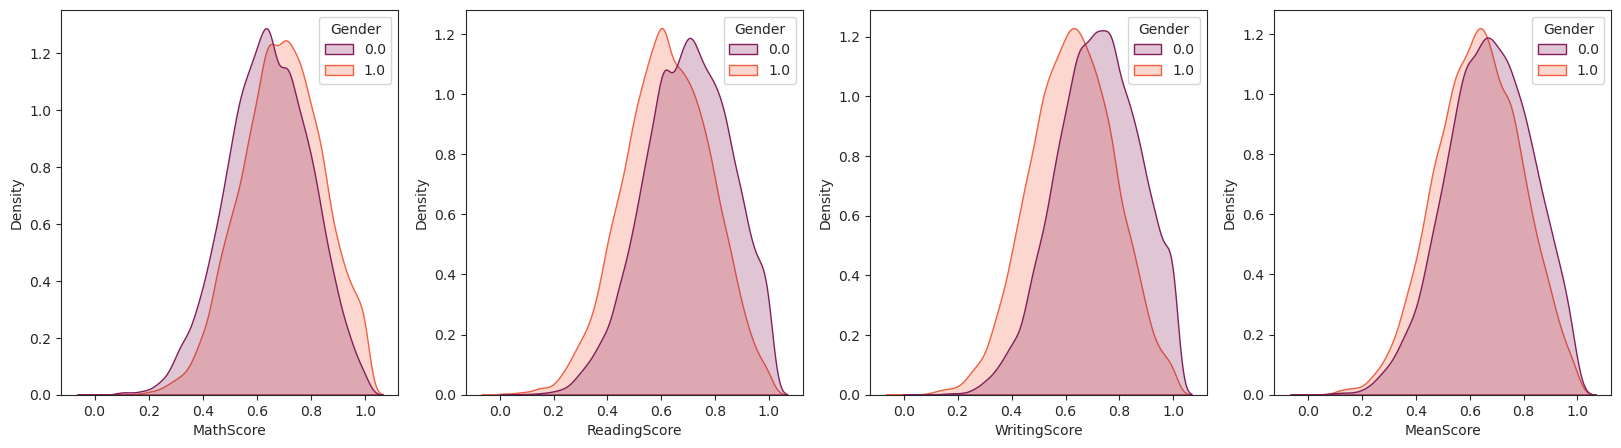

In [23]:
fig,ax = plt.subplots(ncols=4,figsize=(20,5))
ax = ax.flat
for i,k in enumerate(cols_objective+["MeanScore"]):
    sns.kdeplot(data=data_norm,x=k,hue="Gender",ax=ax[i],palette="rocket",fill=True)

/home/adrian/miniconda3/envs/adat/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


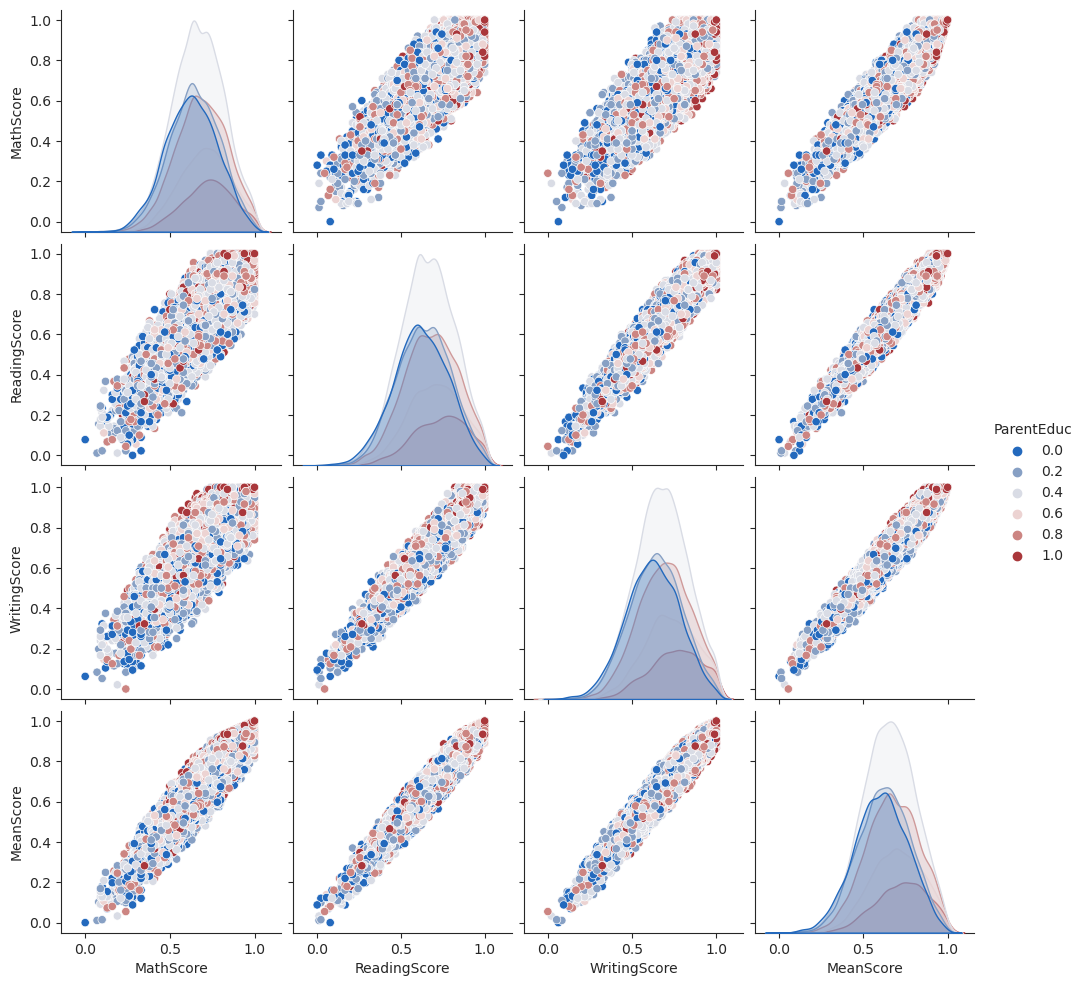

In [24]:

sns.pairplot(data=data_norm[list(cols_objective+["MeanScore","ParentEduc"])],
            kind="scatter",
            hue="ParentEduc",
            palette="vlag"
            )

En el caso de "MathScore" el género 1 tiene su valor promedio más hacia la derecha que el género, 0; sin embargo, en "ReadingScore" y "WritingScore" se tiene el caso contrario.

Al mezclar los 3 score en uno sólo, la diferencia desaparece. veamos  la distribución del género

,Gender
0.0,15424
1.0,15217


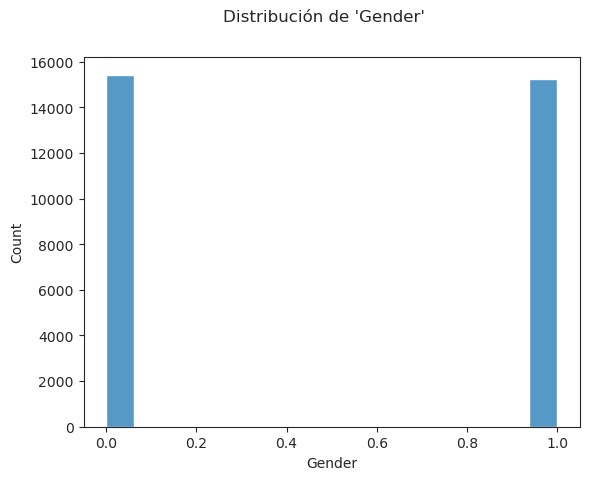

In [25]:
display(pd.DataFrame({"Gender":pd.get_dummies(data_norm["Gender"]).sum(axis=0).replace(to_replace={True:"Male",False:"Female"})}))
sns.histplot(data_norm["Gender"].replace(to_replace={True:"Male",False:"Female"}),bins=bins)
plt.suptitle("Distribución de 'Gender'")
plt.show()




# <span style="color:rgb(180,200,0)">Selección de variables</span>



Ahora la idea es comparar los parámetros de distribución de las calificaciones para evaluar si conviene escribirlas como en promedio de las 3 o separadas. al criterio es, si los parámetros son parecidos, entonces vale la pena describirlas como una sola, en otro acso no.

### Fit de las distribuciones de notas a distribuciones estadisticas
Con `Fitter` se evaluará cuál distribución estadística es la que mejor ajusta y sobre ella se evaluará los datos.

Para optimizar tiempo usaré `multiprocessing.Pool`

Text(0.5, 0.98, 'objectives correlation')

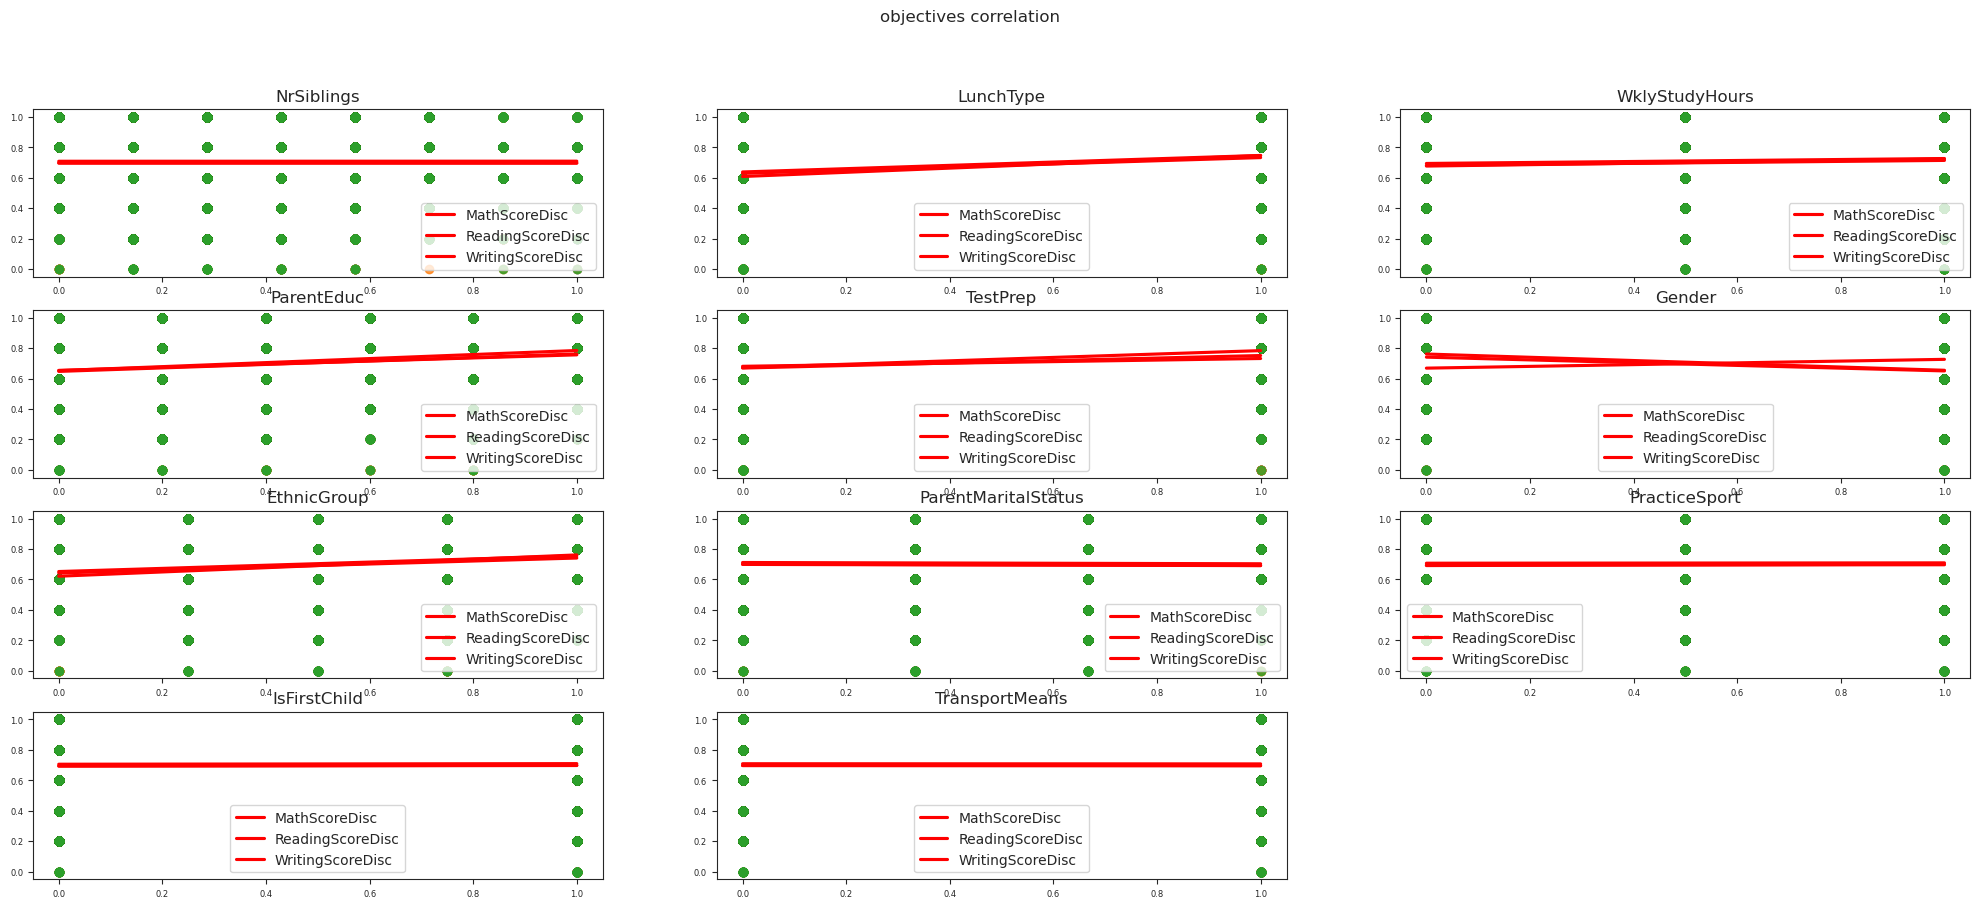

In [26]:
fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(25,10))
axes = axes.flat
column_names = data_norm.drop(list(cols_objective +cols_objective_disc + ["MeanScore",'MeanScoreDisc']),axis=1).columns.values

for i,col in enumerate(column_names):
    for name in cols_objective_disc:
        sns.regplot(    
            x = data_norm[col],
            y = data_norm[name],
            ax=axes[i],
            line_kws={"color":"r","alpha":1,"label":name},
        )

    axes[i].legend()
    axes[i].set_title(f"{col}")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.delaxes(axes[-1])
fig.suptitle("objectives correlation")

## Análisis de variables con Scikit-Learn

### importar los módulos de selección

se usará la métrica de $\chi^{2}$, Fisher para seleccionar las variables que más influyen se relacionan con el objetivo (las calificaciones)

In [27]:
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.feature_selection import RFE # recursive feature elimination
from sklearn.ensemble import ExtraTreesClassifier #decision trees 

In [28]:
data = data_norm

In [29]:
cols_objective_train = list(cols_objective_disc)
training = data.drop(labels=cols_objective_train+ cols_objective + ['MeanScore','MeanScoreDisc'],axis=1)
target = data[cols_objective_train+ cols_objective + ['MeanScore','MeanScoreDisc']]
display(training.head())

,NrSiblings,LunchType,WklyStudyHours,ParentEduc,TestPrep,Gender,EthnicGroup,ParentMaritalStatus,PracticeSport,IsFirstChild,TransportMeans
0,0.428571,1.0,0.0,0.6,0.0,0.0,0.50,0.333333,0.5,1.0,1.0
1,0.000000,1.0,0.5,0.4,0.0,0.0,0.50,0.333333,1.0,1.0,1.0
2,0.571429,1.0,0.0,1.0,0.0,0.0,0.25,0.666667,1.0,1.0,1.0
3,0.142857,0.0,0.5,0.8,0.0,1.0,0.00,0.333333,0.0,0.0,1.0
4,0.000000,1.0,0.5,0.4,0.0,1.0,0.50,0.333333,1.0,1.0,1.0


In [30]:
result = []
for l,target_col in enumerate(cols_objective_train):

    k = 4  # número de atributos a seleccionar

    columnas = list(training.columns.values)
        
    seleccionadas = SelectKBest(score_func=f_classif,k=k).fit(training,target[target_col]).get_support()
    atributos = [columnas[i] for i in list(seleccionadas.nonzero()[0])]
    
    result.append(pd.DataFrame({target_col:atributos}))
result = pd.concat(result,axis=1)
display(result)



,MathScoreDisc,ReadingScoreDisc,WritingScoreDisc
0,LunchType,LunchType,LunchType
1,ParentEduc,ParentEduc,ParentEduc
2,Gender,TestPrep,TestPrep
3,EthnicGroup,Gender,Gender


En ese sentido vamos a ver la correlación de las variables con lo que se busca predecir

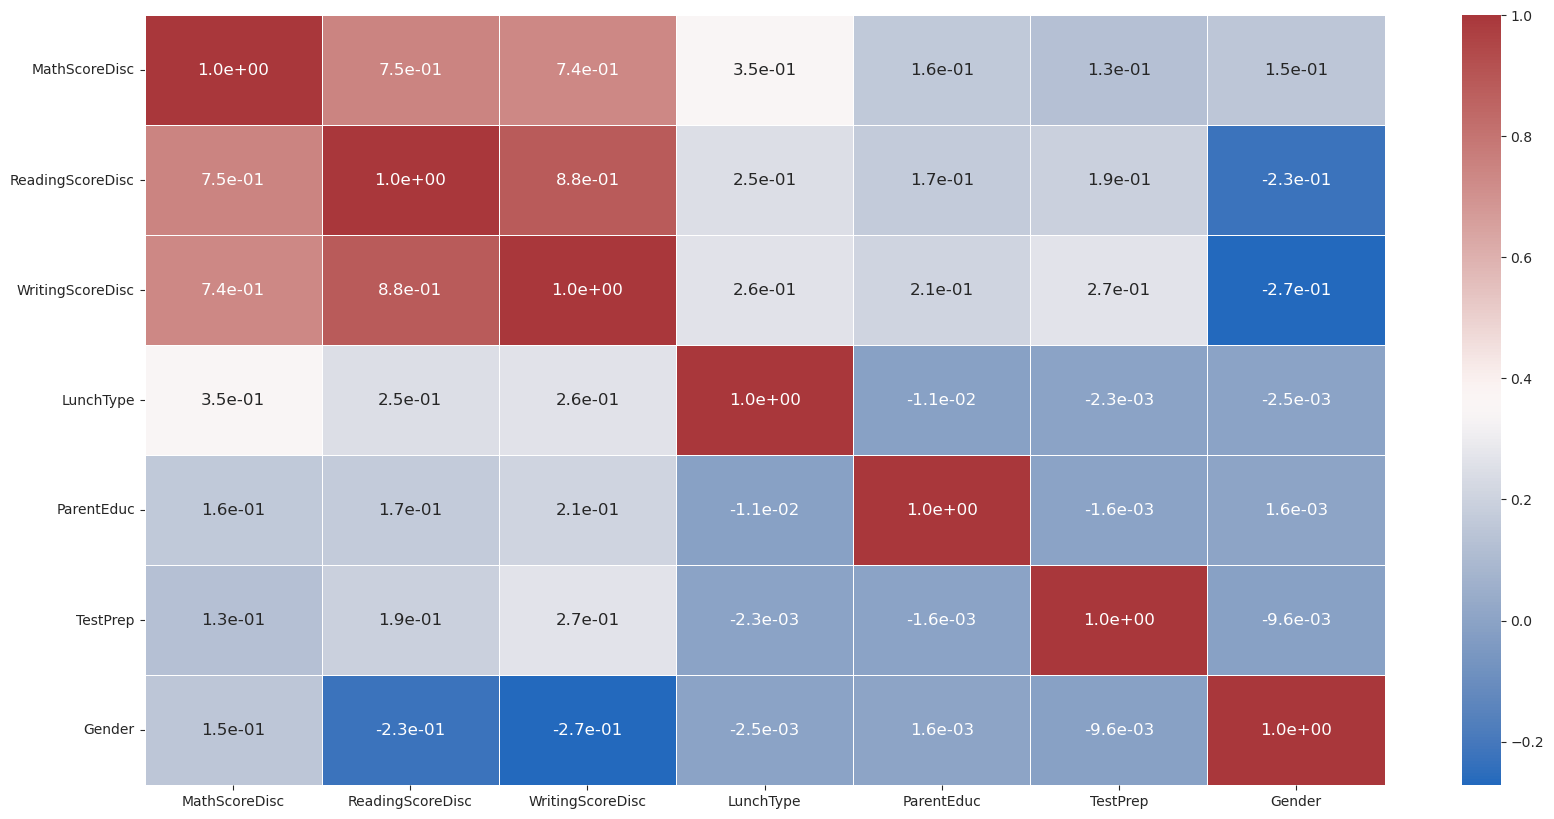

Text(0.5, 0.98, 'Correlación del objetivo con las variables seleccionadas')

<Figure size 640x480 with 0 Axes>

In [31]:
cols_selected = atributos
data_selected = data[list(cols_objective_train + cols_selected)]
corr_matrix(data_selected)
plt.suptitle("Correlación del objetivo con las variables seleccionadas",fontsize=3*fntsz)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

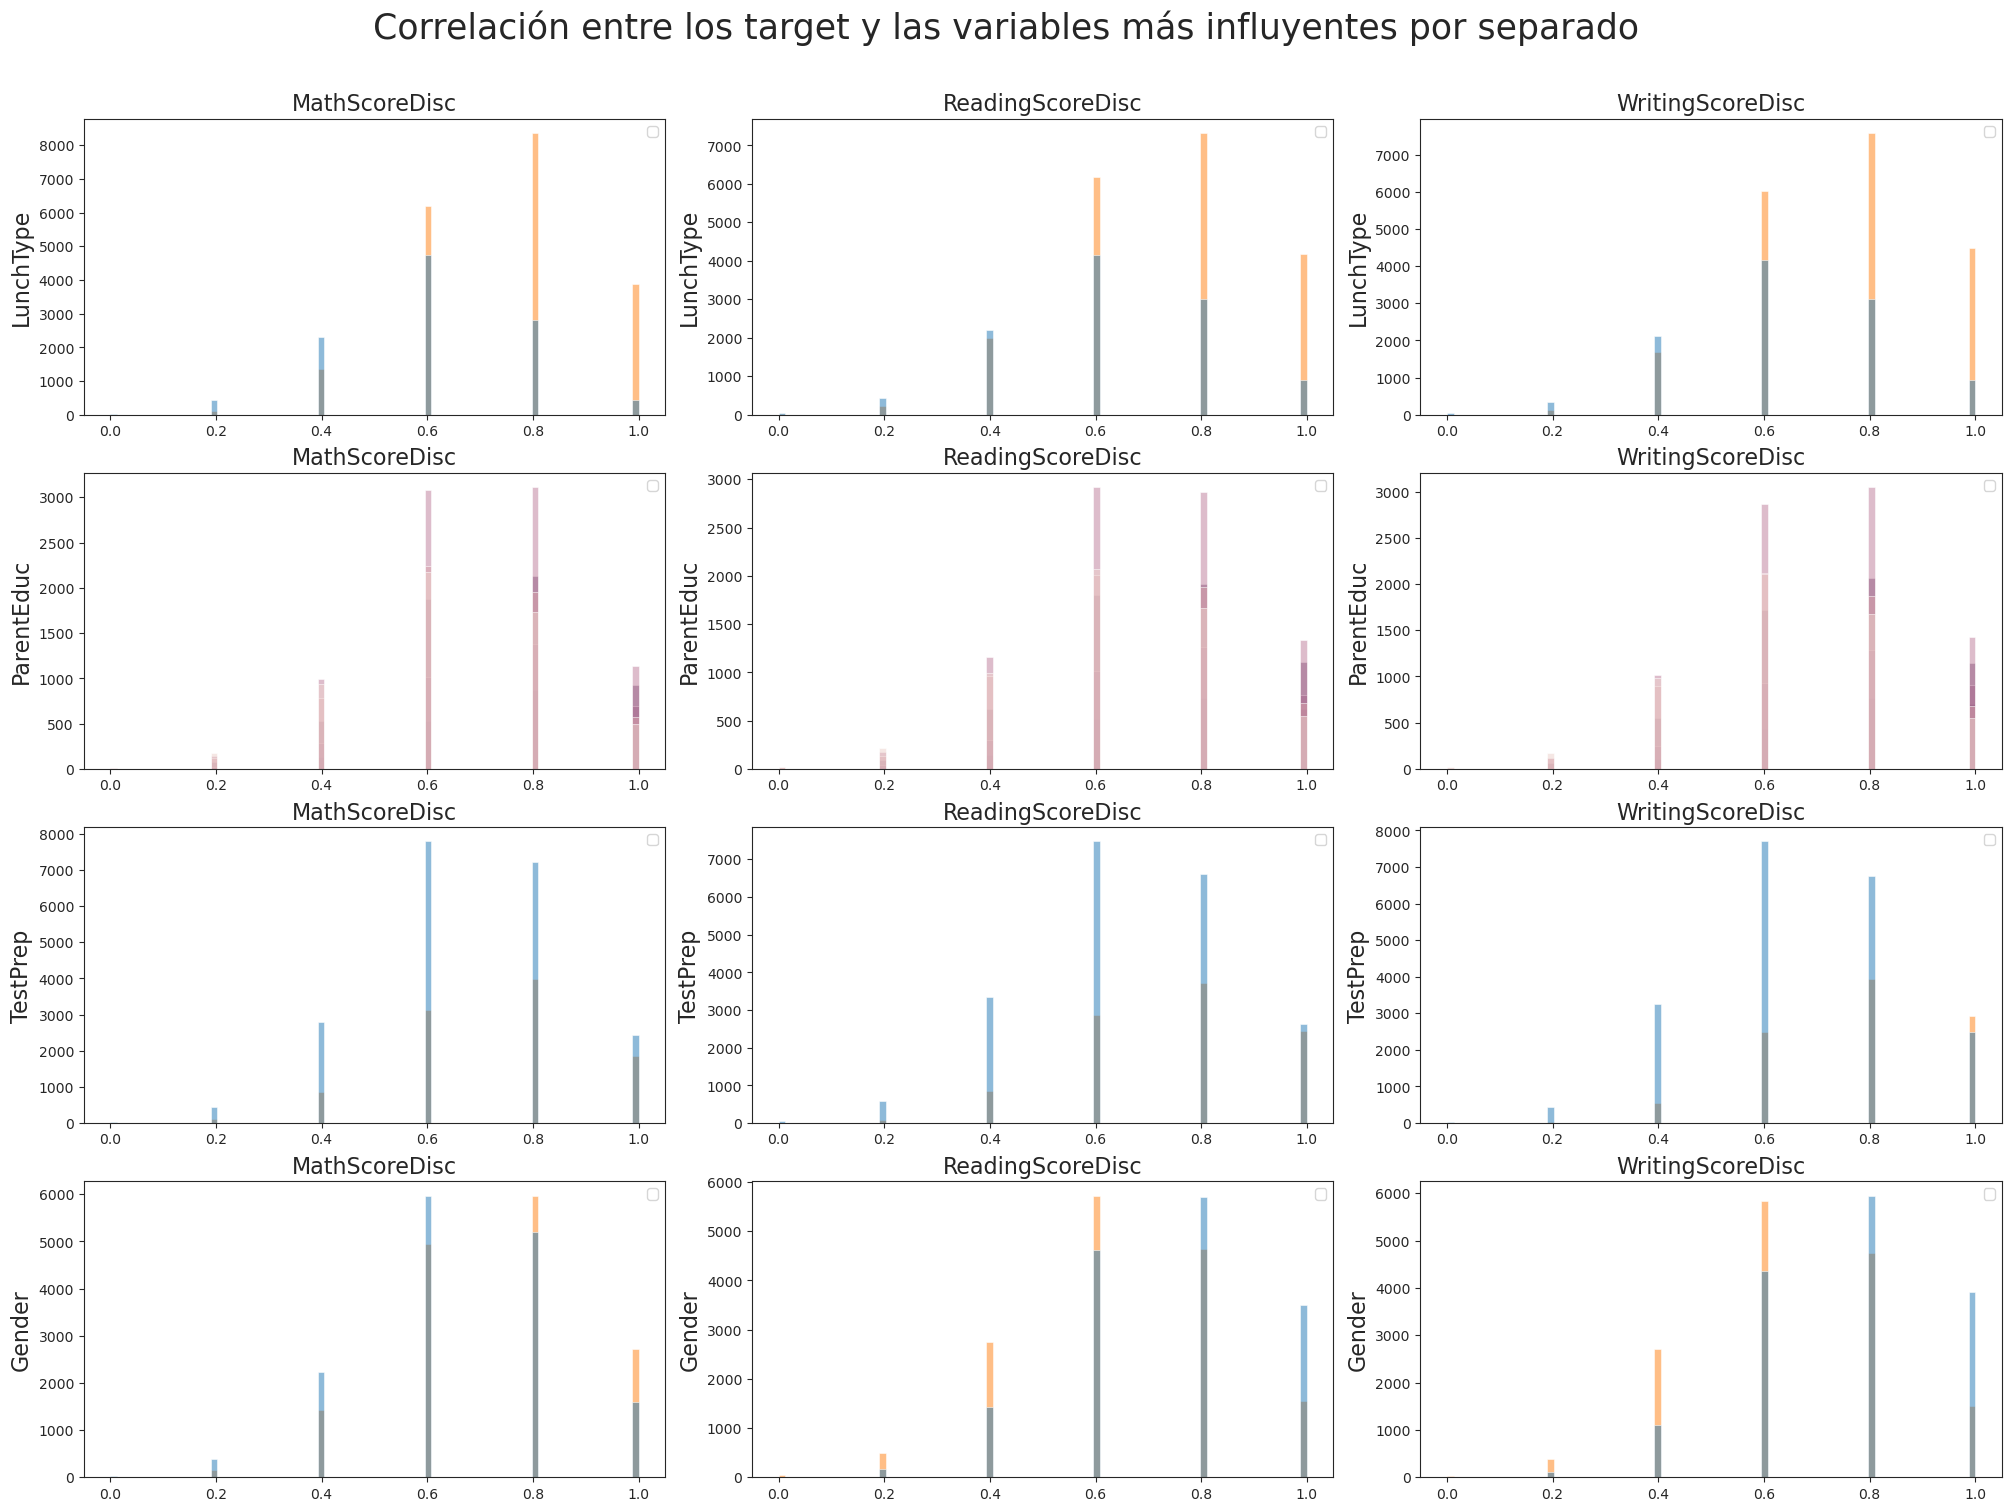

In [32]:

fig, axes = plt.subplots(nrows=round(len(cols_selected)),ncols=round(len(cols_objective_train)),figsize=(20,15),constrained_layout=True)

for i, atrib in enumerate(cols_selected):
    for m in range(len(cols_objective_train)):
        sns.histplot(data=data,x=cols_objective_train[m],hue=atrib,ax=axes[i,m],fill=True)
        axes[i,m].set_title(cols_objective_train[m],fontsize=16)
        axes[i,m].set_xlabel("")
        axes[i,m].set_ylabel(atrib,fontsize=16)
        axes[i,m].legend()
#fig.tight_layout()
        
fig.suptitle("Correlación entre los target y las variables más influyentes por separado\n",fontsize=25)
plt.show()

# <span style="color:rgb(180,200,0)">Implementación de modelos </span>

## Separar conjunto de variables relevantes

las variables relevantes que influyen en las características de las 3 calificaciones son 

1. `LunchType`
2. `ParentEduc`

In [33]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

### Separar dataset

## K-vecinos

In [34]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

precisión con K vecinos en entreno es 0.032
precisión con K vecinos prueba es 0.039
precisión con K vecinos en entreno es 0.032
precisión con K vecinos prueba es 0.039


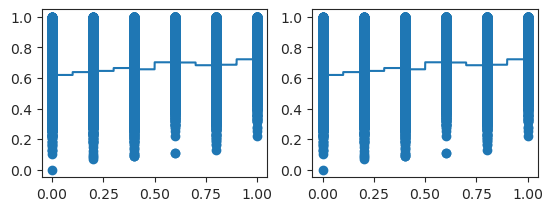

In [35]:
n_neighbors = int(1e3)

x = data[["ParentEduc"]].values

y = [data[cols_objective].iloc[:,k].values for k in range(len(cols_objective))]

x_train,x_test,y_train,y_test = train_test_split(x,y[0],train_size=0.7)

ls = np.linspace(0,1,sz[0])[:,np.newaxis]

for i,weights in enumerate(['uniform','distance']):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors,weights=weights,n_jobs=ncpu())
    y_ = knn.fit(x,y[0]).predict(ls)
    print(f"precisión con K vecinos en entreno es {knn.score(x_train,y_train):1.3f}")
    print(f"precisión con K vecinos prueba es {knn.score(x_test,y_test):1.3f}")
    plt.subplot(2,2,1+i)
    plt.scatter(x,y[0],label="data")
    plt.plot(ls,y_,label="prediction")
    plt.axis('tight')
    



## Árboles de decisión

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [37]:
#y = data[["MeanScore"]].values
y = data['MathScoreDisc'].values.reshape(-1,1)
x = data['LunchType'].values.reshape(-1,1)

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7)

In [38]:
clasif = DecisionTreeClassifier()
param_grid = {'criterion':['gini','entropy'],'max_depth':[2]}

grid_search = GridSearchCV(clasif,param_grid=param_grid,cv=10,return_train_score=True,n_jobs=ncpu()-1,error_score='raise')
grid_search.fit(x_train,y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

ValueError: Unknown label type: 'continuous'

In [ ]:
pd.DataFrame(np.histogram(data[["MeanScore"]],bins=5)[1]).values

## Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
## Dont forget

#print(pd.get_dummies(data[["ParentEduc"]],prefix='',prefix_sep='').columns.values)